In [4]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy
from pprint import pprint

In [38]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 14,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [6]:
api = wandb.Api()

In [29]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter, include_configs = None):
    all_interp_data = []
    if include_configs is None:
        include_configs = []
    for group, x_key, y_key in group_and_keys:
        total_filters = {
            "$and": [
                {"group": group},
                {"$not": {"tags": "exclude-from-paper"}},
                extra_filter,
            ]
        }
        pprint(total_filters)
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters=total_filters,
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                if np.max(h[x_key]) < 0.99 * x_range[1]:
                    print("Maximum x value of run", str(r), "is", np.max(h[x_key]))
                    continue
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                df = pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                for inc_cfg in include_configs:
                    df[relabel_dict.get(inc_cfg, inc_cfg)] = r.config.get(inc_cfg, None)
                all_interp_data.append(df)
    return pd.concat(all_interp_data, ignore_index=True)

In [35]:
env = "Walker2d-v3"
group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "update/fixup_grad_steps"),
]
relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'update/fixup_grad_steps': 'Fixup Phase Gradient Steps',
    'target_coeff': '$C_{beta}$',
}

configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': env, 'eps_kl': 0.5}
# configs = {'fixup_loop': 1, 'env': env}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            *({f"config.{k}": v} for k, v in configs.items()),
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
    include_configs = ['target_coeff']
)

{'$and': [{'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.fixup_loop': 1},
                    {'config.fixup_every_repeat': 1},
                    {'config.env': 'Walker2d-v3'},
                    {'config.eps_kl': 0.5},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 90 runs for group fixpo-tianshou-mujoco


In [36]:
all_data

,Total Environment Steps,Fixup Phase Gradient Steps,Algorithm,run,$C_{beta}$
0,0.000000e+00,4.714286,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3
1,3.003003e+03,4.714286,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3
2,6.006006e+03,4.714286,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3
3,9.009009e+03,4.714286,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3
4,1.201201e+04,4.714286,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/zyslhuob (finis...,3
...,...,...,...,...,...
89995,2.987988e+06,26.065035,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2
89996,2.990991e+06,26.062591,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2
89997,2.993994e+06,26.060148,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2
89998,2.996997e+06,26.057704,fixpo-tianshou-mujoco,<Run resl-mixppo/stabilized-rl/bc4sq93u (finis...,2


/tmp/ipykernel_778542/928819632.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


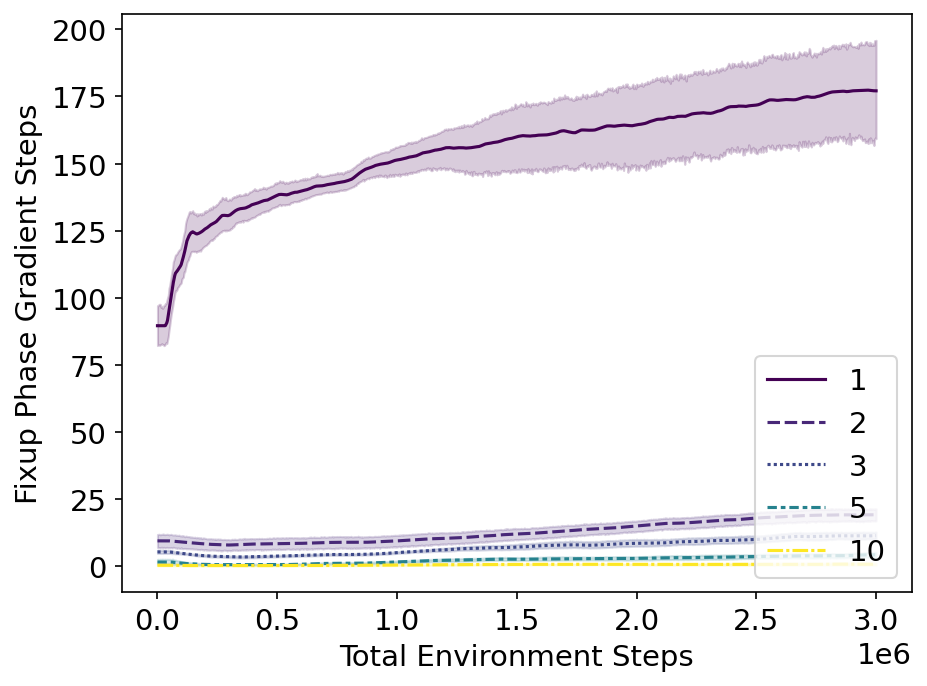

In [39]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Fixup Phase Gradient Steps",
    hue='$C_{beta}$',
    ci=95,
    style='$C_{beta}$',
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"fixup_phase_vs_c_beta_{env}.pdf")